In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import dill
import json

In [3]:
# for data
from classifiers.datasets import SklearnDataset
# for QASVM
from classifiers.quantum.qasvm import SoftQASVM, PseudoSoftQASVM
from classifiers.convex.svm import CvxSoftQASVM
from classifiers.quantum.ansatz import Circuit9, sample_circuit, MultilayerCircuit9FeatureMap
from classifiers.callback import CostParamStorage
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator, StatevectorSimulator, Aer, QasmSimulator
# for optimization
from qiskit.algorithms.optimizers import SPSA, ADAM
from tqdm.notebook import tqdm

In [4]:
import random
random_seed = random.randint(0, 9999)
random_seed

1026

In [5]:
training_size, test_size = (64, 86)
lamda, C = (10**4, 10**4)
true_hot = 0

In [6]:
dataset = SklearnDataset('iris', feature_range=(-np.pi, np.pi), true_hot=None)
data, lable, label_names, features = dataset.data, dataset.target, dataset.target_names, dataset.feature_names

classes = list(label_names)
training_set, test_set = SklearnDataset('iris', feature_range=(-np.pi, np.pi), true_hot=true_hot).sample_training_and_test_dataset((training_size, test_size), random_state = random_seed)
training_data = training_set[features].to_numpy()
training_label = training_set['target'].to_numpy()
test_data = test_set[features].to_numpy()
test_label = test_set['target'].to_numpy()

In [18]:
qasm_backend = QuantumInstance(backend=QasmSimulator(device='CPU', shots=2**13), shots=2**10)
sv_backend = QuantumInstance(backend=StatevectorSimulator(device='CPU', shots=2**13), shots=2**13)

In [8]:
if training_size==64:
    var_form = sample_circuit(15)(num_qubits=int(np.log2(training_size)), reps=5)
else:
    var_form = sample_circuit(15)(num_qubits=int(np.log2(training_size)), reps=11)

MAXITER = 2**13

In [9]:
from tqdm import tqdm

feature_map = MultilayerCircuit9FeatureMap(4, 2)

__qasvm = PseudoSoftQASVM(
        training_data, training_label, lamda=lamda, C=C,
        quantum_instance=sv_backend,
        var_form=None,
        feature_map=feature_map
    )
kernel_matrix = __qasvm.kernel_matrix
test_matrix = __qasvm._qk.evaluate(test_data, training_data)

In [10]:
svm = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm.fit(kernel_matrix, training_label)
true_fvec = svm.f(test_matrix)

In [19]:
sv_qasvm = PseudoSoftQASVM(
    data=training_data, label=training_label,
    quantum_instance=sv_backend,
    feature_map=feature_map,
    var_form=var_form,
    lamda=lamda, C=C
)
qasm_qasvm = SoftQASVM(
    data=training_data, label=training_label,
    quantum_instance=qasm_backend,
    feature_map=feature_map,
    var_form=var_form,
    lamda=lamda, C=C
)
qasm_qasvm.initial_point = sv_qasvm.initial_point

In [12]:

# with tqdm(total=MAXITER) as sv_pbar:
#     sv_pbar.set_description('training(sv)')
#     sv_storage = CostParamStorage()
#     def _callback(*args):
#         sv_pbar.update()
#         sv_storage(*args)
#     optimzer = SPSA(maxiter=MAXITER, blocking=True, callback=_callback)#, termination_checker=sv_storage.termination_checker(last_avg=16))
#     result = optimzer.minimize(sv_qasvm.cost_fn, sv_qasvm.initial_point)
# sv_qasvm.parameters = sv_storage.last_avg(16, ignore_rejected=True)
# sv_fvec = sv_qasvm.f(test_data)

training(sv): 100%|██████████| 8192/8192 [07:43<00:00, 17.66it/s]


In [20]:
with tqdm(total=MAXITER, desc='training(qasm)') as qasm_pbar:
    qasm_storage = CostParamStorage()
    def _callback(*args):
        qasm_pbar.update()
        qasm_storage(*args)
    optimzer = SPSA(maxiter=MAXITER, blocking=True, callback=_callback)#, termination_checker=qasm_storage.termination_checker(last_avg=16))
    result = optimzer.minimize(qasm_qasvm.cost_fn, qasm_qasvm.initial_point)
qasm_qasvm.parameters = qasm_storage.last_avg(16, ignore_rejected=True)
qasm_fvec = qasm_qasvm.f(test_data)

training(qasm):  80%|████████  | 6592/8192 [53:00:36<12:30:54, 28.16s/it]

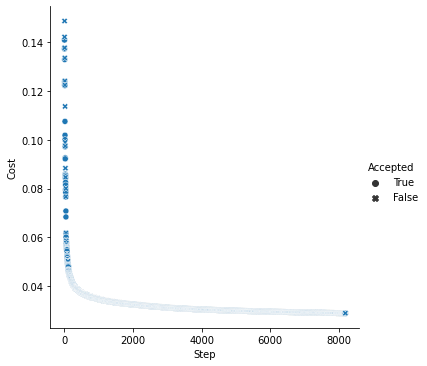

In [14]:
sv_storage.plot()

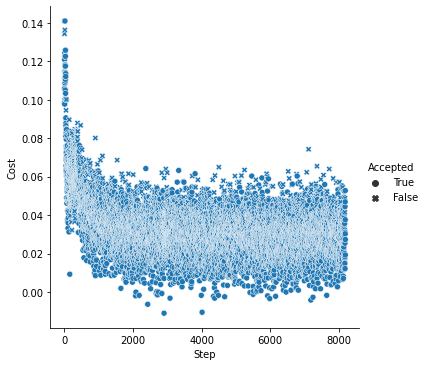

In [ ]:
qasm_storage.plot()

In [ ]:
# sv_storage.save('./_R_1024sv_storage')
qasm_storage.save('./qasm_storage_R_1024')
sv_qasvm.save('./sv_qasvm_R_1024')
qasm_qasvm.save('./qasm_qasvm_R_1024')
# np.save('./sv_fvec_R_1024', sv_fvec)
np.save('./qasm_fvec_R_1024', qasm_fvec)
np.save('./training_data_R_1024', training_data)
np.save('./test_data_R_1024', test_data)
np.save('./training_label_R_1024', training_label)
np.save('./test_label_R_1024', test_label)